# 0. 버전확인

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


# Step 1. 데이터 수집하기
### 한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

Cloud shell에서 아래 명령어를 입력해 주세요.

$ mkdir -p ~/aiffel/transformer_chatbot/data/
$ ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

# Step 2. 데이터 전처리하기
### 영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

=3


In [3]:
data = pd.read_csv(os.path.expanduser("~/aiffel/transformer_chatbot/data/ChatbotData .csv"))

In [4]:
num_samples = len(data)
print("샘플 개수:", num_samples)

샘플 개수: 11823


In [5]:
data.head()
# A열의 2, 3행이 "여행은 언제나 좋죠." 로 중복값인 것을 확인함. 각 열의 중복값과 누락값을 확인하고자함.

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [6]:
# Q열과 A열 각각의 누락값 개수 확인
q_missing = data['Q'].isnull().sum()
a_missing = data['A'].isnull().sum()

print("Q 열의 누락값 개수:", q_missing)
print("A 열의 누락값 개수:", a_missing)

Q 열의 누락값 개수: 0
A 열의 누락값 개수: 0


In [7]:
# Q열과 A열 각각의 중복값 개수 확인
q_duplicates = data['Q'].duplicated().sum()
a_duplicates = data['A'].duplicated().sum()

print("Q 열의 중복값 개수:", q_duplicates)
print("A 열의 중복값 개수:", a_duplicates)

Q 열의 중복값 개수: 161
A 열의 중복값 개수: 4044


In [8]:
# 중복값을 갖는 Q열 데이터 확인
duplicate_q_data = data[data['Q'].duplicated(keep=False)]

print("중복값을 갖는 Q 열 데이터:")
print(duplicate_q_data)


중복값을 갖는 Q 열 데이터:
                             Q                        A  label
152    결혼이나 하지 왜 자꾸 나한테 화 내냐구!                   힘들겠네요.      0
189             고백하고 후회하면 어떡하지  후회는 후회를 낳을뿐이에요. 용기 내세요.      0
195                 고양이 키우고 싶어             자신을 먼저 키우세요.      0
196                 고양이 키우고 싶어             가족들과 상의해보세요.      0
226          공부는 내 체질이 아닌 것 같아                확신이 없나봐요.      0
...                        ...                      ...    ...
11658                  첫사랑 생각나           지금의 사랑에 충실하세요.      2
11731    커플여행이 나을까 그냥 우리끼리 갈까?         저는 둘이 가는 걸 좋아해요.      2
11732    커플여행이 나을까 그냥 우리끼리 갈까?          저는 둘이 가는 게 좋아요.      2
11818           훔쳐보는 것도 눈치 보임.       티가 나니까 눈치가 보이는 거죠!      2
11819           훔쳐보는 것도 눈치 보임.            훔쳐보는 거 티나나봐요.      2

[317 rows x 3 columns]


In [9]:
# Q열과 A열이 동시에 중복값을 갖는 데이터 확인
duplicate_qa_data = data[data.duplicated(subset=['Q', 'A'], keep=False)]

# 중복값의 개수 확인
num_duplicates = duplicate_qa_data.shape[0]

print("Q 열과 A 열이 동시에 중복값을 갖는 데이터 개수:", num_duplicates)
print("중복된 Q와 A 열 데이터:")
print(duplicate_qa_data)


Q 열과 A 열이 동시에 중복값을 갖는 데이터 개수: 146
중복된 Q와 A 열 데이터:
                            Q                        A  label
152   결혼이나 하지 왜 자꾸 나한테 화 내냐구!                   힘들겠네요.      0
189            고백하고 후회하면 어떡하지  후회는 후회를 낳을뿐이에요. 용기 내세요.      0
226         공부는 내 체질이 아닌 것 같아                확신이 없나봐요.      0
377                  기숙사 괜찮을까         혼자 사는 것보다 불편하겠죠.      0
592                 나는 좋은데 ….           현실의 벽에 부딪혔나봐요.      0
...                       ...                      ...    ...
8764                   환승 가능?               환승은 30분 안에      1
8780          회사 사람들이 아직도 불편해        회사에는 동료가 있을 뿐이에요.      1
8782     회사에는 왜 친구 같은 사람이 없을까      회사는 친구 사귀는 곳이 아니에요.      1
8789                    후련하달까              후련하니 다행이에요.      1
9541             내일 만나자고 해볼까?         멋지게 데이트 신청 해보세요.      2

[146 rows x 3 columns]


In [10]:
# 152번째 데이터의 Q와 A 값
target_q = data.loc[152, 'Q']
target_a = data.loc[152, 'A']

# 152번째 데이터와 같은 Q와 A 값을 갖는 데이터의 인덱스 찾기
duplicate_indices = data[(data['Q'] == target_q) & (data['A'] == target_a)].index.tolist()

print("152번째 데이터와 중복값을 갖는 데이터의 인덱스:", duplicate_indices)


152번째 데이터와 중복값을 갖는 데이터의 인덱스: [152, 5527]


In [11]:
# 5527번 데이터 출력
print(data.loc[5527])

Q        결혼이나 하지 왜 자꾸 나한테 화 내냐구!
A                         힘들겠네요.
label                          1
Name: 5527, dtype: object


In [12]:
# Q와 A 열이 동시에 같은 데이터를 하나만 남기고 삭제
data = data.drop_duplicates(subset=['Q', 'A'], keep='first').reset_index(drop=True)

# 결과 확인
print(data.head())

                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


In [13]:
num_samples = len(data)
print("샘플 개수:", num_samples)

샘플 개수: 11750


In [14]:
import re

# 한글 불용어 목록
stopwords = [
    "이", "그", "저", "가", "을", "를", "에", "의", "와", "과", "들"
]

def preprocess_korean_text(data):
    processed_texts = []
    
    for sentence in data:
        # 구두점 처리
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        
        # 중복 공백 제거
        sentence = re.sub(r'\s+', ' ', sentence)
        
        # 양쪽 공백 제거
        sentence = sentence.strip()
        
        processed_texts.append(sentence)
    
    return processed_texts

def remove_stopwords(data, stopwords):
    filtered_texts = []
    
    for sentence in data:
        # 텍스트를 공백으로 분리하여 단어 리스트 생성
        words = sentence.split()
        
        # 불용어가 아닌 단어만 필터링
        filtered_words = [word for word in words if word not in stopwords]
        
        # 필터링된 단어를 다시 문자열로 결합
        filtered_texts.append(' '.join(filtered_words))
    
    return filtered_texts


# Q열과 A열에 각각 전처리 및 불용어 제거 적용
data['Q_processed'] = preprocess_korean_text(data['Q'])
data['A_processed'] = preprocess_korean_text(data['A'])

data['Q_filtered'] = remove_stopwords(data['Q_processed'], stopwords)
data['A_filtered'] = remove_stopwords(data['A_processed'], stopwords)

# 결과 확인
print(data[['Q', 'Q_filtered', 'A', 'A_filtered']].head())


                 Q       Q_filtered            A    A_filtered
0           12시 땡!          12시 땡 !   하루가 또 가네요.   하루가 또 가네요 .
1      1지망 학교 떨어졌어      1지망 학교 떨어졌어    위로해 드립니다.    위로해 드립니다 .
2     3박4일 놀러가고 싶다     3박4일 놀러가고 싶다  여행은 언제나 좋죠.  여행은 언제나 좋죠 .
3  3박4일 정도 놀러가고 싶다  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.  여행은 언제나 좋죠 .
4          PPL 심하네          PPL 심하네   눈살이 찌푸려지죠.   눈살이 찌푸려지죠 .


In [15]:
# Q_filtered와 A_filtered 열의 개수 확인
q_filtered_count = data['Q_filtered'].count()
a_filtered_count = data['A_filtered'].count()

print("Q_filtered 열의 개수:", q_filtered_count)
print("A_filtered 열의 개수:", a_filtered_count)


Q_filtered 열의 개수: 11750
A_filtered 열의 개수: 11750


In [16]:
# Q열과 A열 삭제
data = data.drop(columns=['Q', 'A', 'Q_processed', 'A_processed'])
print(data.head())

   label       Q_filtered    A_filtered
0      0          12시 땡 !   하루가 또 가네요 .
1      0      1지망 학교 떨어졌어    위로해 드립니다 .
2      0     3박4일 놀러가고 싶다  여행은 언제나 좋죠 .
3      0  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠 .
4      0          PPL 심하네   눈살이 찌푸려지죠 .


In [17]:
# 열 이름 변경
data = data.rename(columns={'Q_filtered': 'questions', 'A_filtered': 'answers'})

# 결과 확인
print(data.head())

   label        questions       answers
0      0          12시 땡 !   하루가 또 가네요 .
1      0      1지망 학교 떨어졌어    위로해 드립니다 .
2      0     3박4일 놀러가고 싶다  여행은 언제나 좋죠 .
3      0  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠 .
4      0          PPL 심하네   눈살이 찌푸려지죠 .


# Step 3. SubwordTextEncoder 사용하기
### 한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용

#### 9-4. 트랜스포머의 입력 이해하기_포지셔널 인코딩 레이어

In [18]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


#### 9-6. 스케일드 닷 프로덕트 어텐션

In [19]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


#### 9-7. 머리가 여러 개인 어텐션_멀티 헤드 어텐션 

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)  # Dense를 적용
    key = self.key_dense(key)        # Dense를 적용
    value = self.value_dense(value)  # Dense를 적용
    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)  # 머리 분리
    key = self.split_heads(key, batch_size)        # 머리 분리
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


#### 9-8. 마스킹

In [21]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [22]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


#### 9-9. 인코더

In [23]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [24]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


#### 9-10. 디코더

In [25]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [26]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


#### 1. 단어장(Vocabulary) 만들기

In [27]:
import tensorflow_datasets as tfds

# 데이터프레임에서 questions와 answers 열을 리스트로 변환
questions = data['questions'].tolist()
answers = data['answers'].tolist()

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**14)
print("작업 완료")

작업 완료


In [28]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("1")

1


In [29]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [21851]
END_TOKEN의 번호 : [21852]


In [30]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

21853


#### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [31]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5170, 1368, 2601]
정수 인코딩 후의 21번째 답변 샘플: [1294, 8659, 6, 6177, 1]


질문의 최소 길이 : 1
질문의 최대 길이 : 16
질문의 평균 길이 : 3.925872340425532
답변의 최소 길이 : 1
답변의 최대 길이 : 23
답변의 평균 길이 : 4.702553191489362


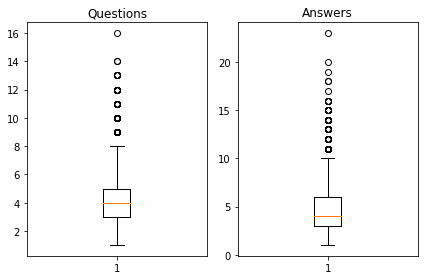

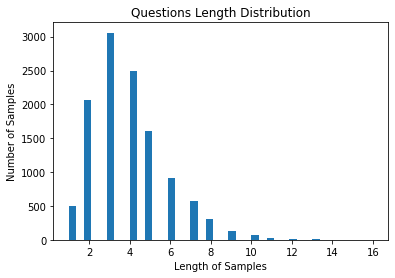

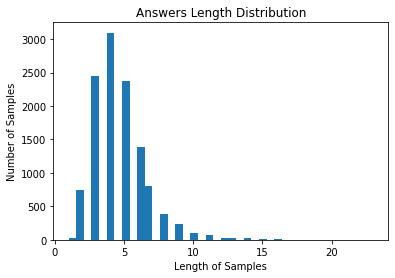

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# 길이 분포 출력
questions_len = [len(s.split()) for s in data['questions']]
answers_len = [len(s.split()) for s in data['answers']]

print('질문의 최소 길이 : {}'.format(np.min(questions_len)))
print('질문의 최대 길이 : {}'.format(np.max(questions_len)))
print('질문의 평균 길이 : {}'.format(np.mean(questions_len)))
print('답변의 최소 길이 : {}'.format(np.min(answers_len)))
print('답변의 최대 길이 : {}'.format(np.max(answers_len)))
print('답변의 평균 길이 : {}'.format(np.mean(answers_len)))

# 길이 분포 시각화
plt.subplot(1, 2, 1)
plt.boxplot(questions_len)
plt.title('Questions')

plt.subplot(1, 2, 2)
plt.boxplot(answers_len)
plt.title('Answers')

plt.tight_layout()
plt.show()

plt.title('Questions Length Distribution')
plt.hist(questions_len, bins=40)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

plt.title('Answers Length Distribution')
plt.hist(answers_len, bins=40)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()


In [33]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 10
print(MAX_LENGTH)

10


### [실험]
### 1. 단어 최대 길이를 길게 해서 모든 데이터를 살리는게 정확도가 높을까?
### 2. 단어 최대 길이를 적게 해서 데이터를 소량만 사용하더라도 패딩을 줄이는 것이 더 정확도가 높을까?

In [34]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("1")

1


In [35]:
# 정수 인코딩 과정을 수행하면서 샘플의 길이가 10을 넘는 경우는 샘플들을 필터링함. 단어장의 크기와 샘플의 개수를 확인
import tensorflow as tf
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 21853
필터링 후의 질문 샘플 개수: 11024
필터링 후의 답변 샘플 개수: 11024


In [36]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


In [37]:
target_vocab_size = 2**14

def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=target_vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


In [38]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.05 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    6648576     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [39]:
# 손실함수 정의

In [40]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


In [41]:
# 커스텀 된 학습률

In [42]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


In [43]:
# 모델 컴파일

In [44]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [45]:
EPOCHS = 10
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

loss = history.history['loss']
accuracy = history.history['accuracy']

Epoch 1/10
173/173 [==============================] - 15s 41ms/step - loss: 5.6295 - accuracy: 0.1368
Epoch 2/10
173/173 [==============================] - 7s 41ms/step - loss: 4.5215 - accuracy: 0.2148
Epoch 3/10
173/173 [==============================] - 7s 41ms/step - loss: 3.5209 - accuracy: 0.2165
Epoch 4/10
173/173 [==============================] - 7s 41ms/step - loss: 3.1269 - accuracy: 0.2207
Epoch 5/10
173/173 [==============================] - 7s 41ms/step - loss: 2.8878 - accuracy: 0.2341
Epoch 6/10
173/173 [==============================] - 7s 40ms/step - loss: 2.6689 - accuracy: 0.2472
Epoch 7/10
173/173 [==============================] - 7s 40ms/step - loss: 2.4412 - accuracy: 0.2680
Epoch 8/10
173/173 [==============================] - 7s 40ms/step - loss: 2.1867 - accuracy: 0.2963
Epoch 9/10
173/173 [==============================] - 7s 39ms/step - loss: 1.9066 - accuracy: 0.3305
Epoch 10/10
173/173 [==============================] - 7s 40ms/step - loss: 1.6023 - accur

In [46]:
print(loss)

[5.629530429840088, 4.521518230438232, 3.520932674407959, 3.1268599033355713, 2.887830972671509, 2.6688735485076904, 2.4411978721618652, 2.18668270111084, 1.906562328338623, 1.602274775505066]


In [47]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [48]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [49]:
output = predict('배고파')

Input: 배고파
Output: 얼른 모아야할 이유가 생겼네요 .


In [50]:
output = predict('오늘 놀러갈거야')

Input: 오늘 놀러갈거야
Output: 이별은 언제나 좋죠 .


In [51]:
output = predict('힘들어')

Input: 힘들어
Output: 저는 위로해드리는 로봇이에요 .


회고

트랜스포머 모델의 인코더와 디코더 구조를 알고 모델을 만드니 과정이 조금은 더 잘 이해가 되었다.
이전에 자연어처리에서 배웠던 문장 평균 길이 구하기 위해 사분위로 나타내는 것과 데이터 표준화 등이 사용되어서 복습이 되었다.

첫번째로 변경한 파라미터는 max_length이다.
max_length를 설정할 때 길이를 길게 해서 모든 데이터를 살리는 대신 패딩이 많이 들어가는게 나을지, 길이를 짧게해서 일부 데이터는 제외시키되 패딩을
적게 넣는 것이 좋을지 고민이 되었는데 데이터의 토큰 길이가 짧다보니 이럴 경우에는 후자가 더 좋다고 했고, 실제로 결과도 accuracy를 봤을 때 더 높았다.

두번째로 변경한 파라미터는 dropout이다.
dropout값을 노드 설정값인 0.1에서 0.05로 낮추었는데 loss 값이 더 증가하였다.
추가적인 실험을 통해 최적화가 더 필요할 것 같다.

마지막으로 알게된 것은 챗봇 모델에서 accuracy보다는 loss 값을 확인하는 것이 더 의미있다고 하였는데 구체적인 설명은 이해를 못했다..

여유롭게 학습해서 좋았다.